# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



# Initialisation

In [1]:
import os
import torch
import networkx as nx
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 20.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#Initialisation
import os
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Analyse du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [3]:

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')
data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [4]:
#premier element
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
#node features
print(f'x = {data.x.shape}')
print(data.x)
#edge index
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

x = torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
edge_index = torch.Size([2, 10556])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


In [6]:
#afficher la MATRICE ADJAcente
from torch_geometric.utils import to_dense_adj
A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (2708, 2708)
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


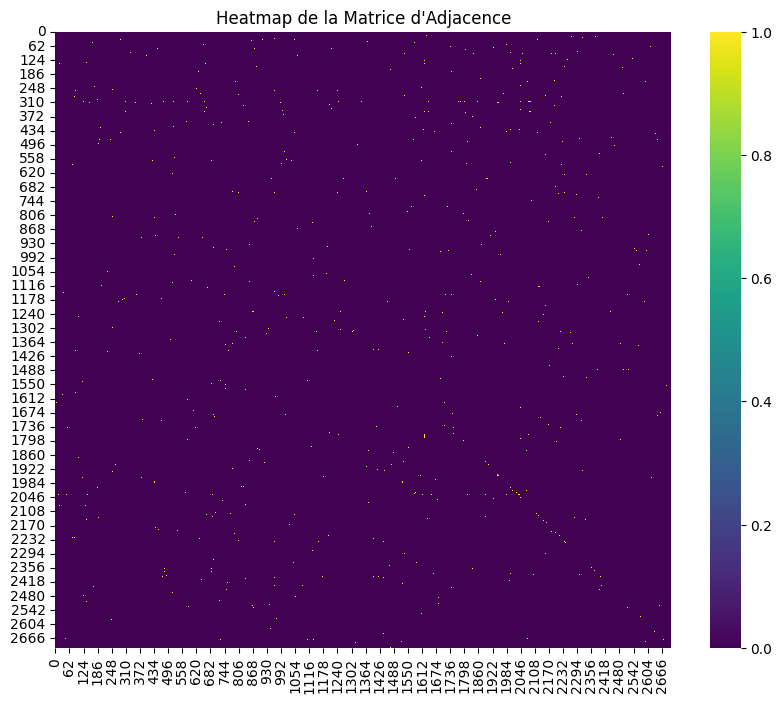

In [7]:
# Créer la heatmap
plt.figure(figsize=(10, 8))  # Vous pouvez ajuster la taille selon vos besoins
sns.heatmap(A, annot=False, cmap='viridis', square=True)
plt.title("Heatmap de la Matrice d'Adjacence")
plt.show()


In [8]:
#afficher labels
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


In [9]:
(data.y).unique() #7 classes

tensor([0, 1, 2, 3, 4, 5, 6])

In [10]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


**Conclusion:**


**- La majorité de la matrice est de couleur foncée, ce qui suggère que la plupart de nœuds ne sont pas directement connectées, indiquant un graphe peu dense. (c'est ce qu'on a vu en affichant que 30 noeuds dessous)**

**- Les points plus clairs en jaune représentent les liens existants entre les nœuds. La répartition de ces points indique que les connexions entre les nœuds ne sont pas régulier et sont dispersées dans tout le graphe.**

**- L'absence de grandes régions continues de couleur claire montre qu'il n'y a pas de grands clusters.**

**- La diagonale n'est pas totalement claire est donc les boucles ne sont pas présentes dans tous les noeuds.**


## Distribution des classes

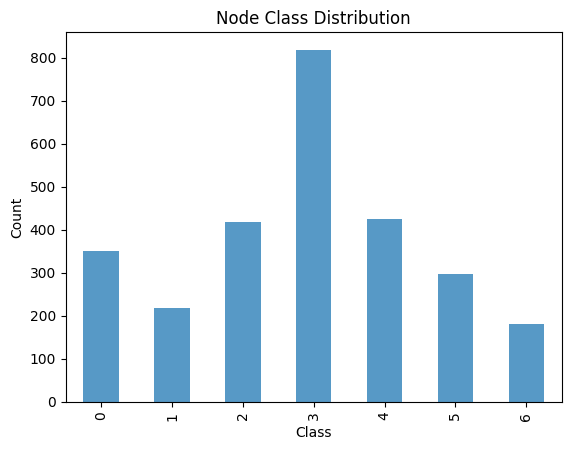

In [11]:
class_distribution = pd.Series(data.y.numpy()).value_counts().sort_index()
class_distribution.plot(kind='bar', alpha=0.75)
plt.title("Node Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

La classe 2 est la plus fréquente avec une nette avance sur les autres classes, et la classe 6 est la moins représentée, ce qui pourrait indiquer un déséquilibre de classe dans le jeu de données.

Cette distribution pourrait affecter la performance du modèle ci-dessous, car les modèles tendent à mieux reconnaître les classes avec plus d'exemples. Comme solution; des techniques comme le suréchantillonnage des classes minoritaires ou le sous-échantillonnage des classes majoritaires. Ces technique pourraient être nécessaires pour améliorer l'équilibre des classes et potentiellement la performance du modèle.

# Afficahge/ Visualisation de graphe

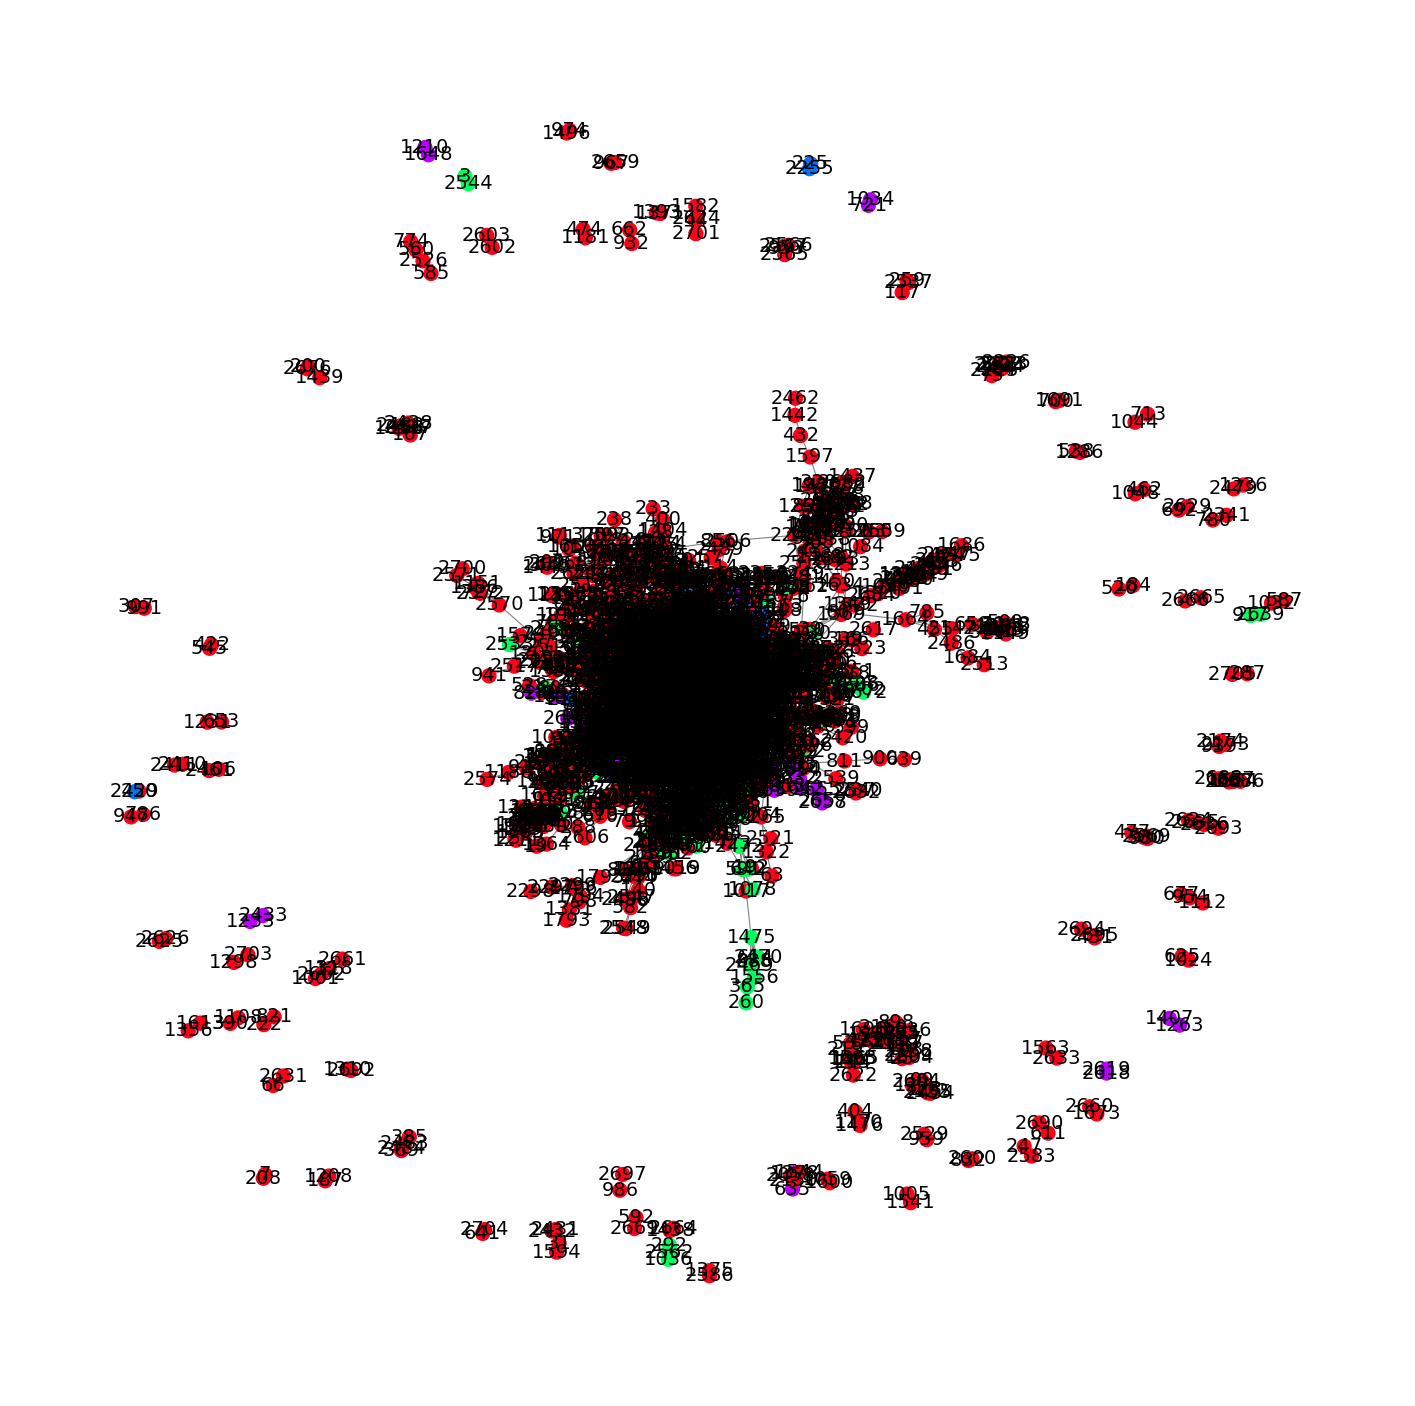

In [12]:
G = to_networkx(data, to_undirected=True) #graphe non derige
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=100,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

Si on veut visualiser que 30 noeuds  

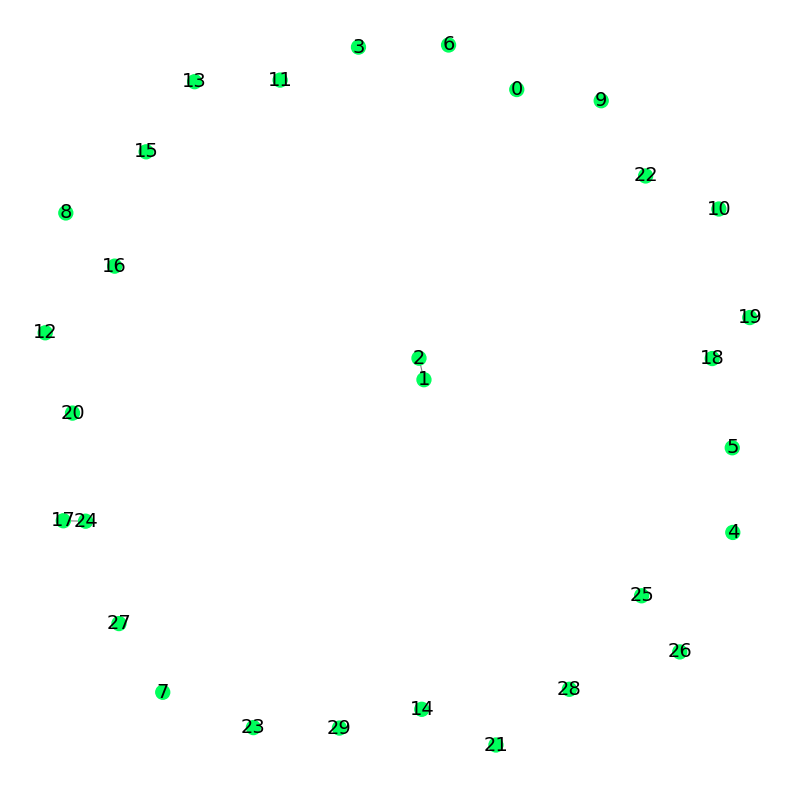

In [13]:
default_value = 0

# Sélection et création du sous-graphe
selected_nodes = list(G.nodes())[:30]
G_sub = G.subgraph(selected_nodes)

# Définir une valeur par défaut pour 'y'
default_value = 0

# Dessiner le sous-graphe
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx(G_sub,
                 pos=nx.spring_layout(G_sub, seed=0),
                 with_labels=True,
                 node_size=100,
                 node_color=[G_sub.nodes[n].get('y', default_value) for n in G_sub.nodes],
                 cmap="hsv",
                 vmin=-2,
                 vmax=3,
                 width=0.8,
                 edge_color="grey",
                 font_size=14
                )
plt.show()


# Question 1 : construire un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.
---




**`les graph attention networks (GAT)`**

In [14]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__() # Initialisation de la superclasse torch.nn.Module
        torch.manual_seed(1234567)
        # Définir la première couche de convolution GAT.
        # Elle prend en entrée le nombre de caractéristiques (features) du dataset, le nombre de canaux cachés par tête d'attention, et le nombre de têtes d'attention.
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)# 2eme couche, elle prend en entrée le nombre de canaux cachés multiplié par le nombre de têtes,
        #et le nombre de classes à prédire dans le dataset

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)# Appliquer un dropout sur les entrées pour la régularisation
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=32, heads=16)
print(model)



GAT(
  (conv1): GATConv(1433, 32, heads=16)
  (conv2): GATConv(512, 7, heads=16)
)


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)# Configuration de l'optimiseur avec la méthode Adam pour ajuster les paramètres du modèle
criterion = torch.nn.CrossEntropyLoss() # Définition de la fonction de perte comme la perte d'entropie croisée

def train(): # fonction d'entraînement du modèle
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) # Propagation avant : calculer les prédictions du modèle sur les données d'entraînement
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward() # Rétropropagation : calcul des gradients de la perte par rapport aux paramètres du modèle
    optimizer.step()# Mise à jour des paramètres du modèle avec les gradients calculés


    # Calcul de la précision d'entraînement
    _, predicted = torch.max(out[data.train_mask], dim=1) # Obtenir les prédictions
    correct = (predicted == data.y[data.train_mask]).sum().item() # Compter les prédictions correctes
    train_acc = correct / data.train_mask.sum().item()  # Calculer la précision
    return loss.item(), train_acc

def test():
    model.eval() # Met le modèle en mode évaluation pour désactiver le dropout.
    with torch.no_grad():# Désactive le calcul des gradients pour économiser de la mémoire et des calculs.
        out = model(data.x, data.edge_index)
         # Calcule la perte de test.
        test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

    return test_loss.item(), test_acc







*  **la perte de test diminue initialement puis se stabilise, indiquant que le modèle ne surapprend pas significativement.**

* **la précision de test augmente et se stabilise, suggérant une bonne généralisation.**



## On va utiliser GridSearch, pour definir les paramétre

In [16]:
import itertools

#Hyperparameter grid
hidden_channels_grid = [32,64,128,256]
heads_grid = [4, 8, 16]
learning_rates = [0.01, 0.005, 0.001]
epochs_grid = [100, 200, 300]  # Different numbers of training epochs

# Grid search loop
for hidden_channels, heads, lr, epochs in itertools.product(hidden_channels_grid, heads_grid, learning_rates, epochs_grid):
    model = GAT(hidden_channels=hidden_channels, heads=heads)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):  # Training for a variable number of epochs
        train_loss, train_acc = train()
        test_loss, test_acc = test()

    print(f"Hidden Channels: {hidden_channels}, Heads: {heads}, LR: {lr}, "
          f"Epochs: {epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Hidden Channels: 32, Heads: 4, LR: 0.01, Epochs: 100, Train Loss: 0.0017, Train Acc: 1.0000, Test Loss: 1.0490, Test Acc: 0.7700
Hidden Channels: 32, Heads: 4, LR: 0.01, Epochs: 200, Train Loss: 0.0061, Train Acc: 0.9929, Test Loss: 1.1907, Test Acc: 0.7780
Hidden Channels: 32, Heads: 4, LR: 0.01, Epochs: 300, Train Loss: 0.0014, Train Acc: 1.0000, Test Loss: 1.2152, Test Acc: 0.7840
Hidden Channels: 32, Heads: 4, LR: 0.005, Epochs: 100, Train Loss: 0.0046, Train Acc: 1.0000, Test Loss: 0.8017, Test Acc: 0.7900
Hidden Channels: 32, Heads: 4, LR: 0.005, Epochs: 200, Train Loss: 0.0027, Train Acc: 1.0000, Test Loss: 1.0711, Test Acc: 0.7650
Hidden Channels: 32, Heads: 4, LR: 0.005, Epochs: 300, Train Loss: 0.0011, Train Acc: 1.0000, Test Loss: 1.0921, Test Acc: 0.7660
Hidden Channels: 32, Heads: 4, LR: 0.001, Epochs: 100, Train Loss: 0.1361, Train Acc: 0.9857, Test Loss: 0.7086, Test Acc: 0.7910
Hidden Channels: 32, Heads: 4, LR: 0.001, Epochs: 200, Train Loss: 0.0356, Train Acc: 0.9929,

**Best Parameters** en se basant sur l'accuracy et loss de test

**Hidden Channels: 64, Heads: 8, LR: 0.001, Epochs: 100, Train Loss: 0.0333, Train Acc: 1.0000, Test Loss: 0.6221, Test Acc: 0.8000**



In [17]:
#On saisie les best parameters
model = GAT(hidden_channels=64, heads=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
#liste pour stocker les valeurs
loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]
epoch_list=[]
# Boucle d'entraînement pour 200 époques.
for epoch in range(1, 101):
    loss, train_acc = train()
    test_loss,test_acc = test()
    loss_list.append(loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    epoch_list.append(epoch)


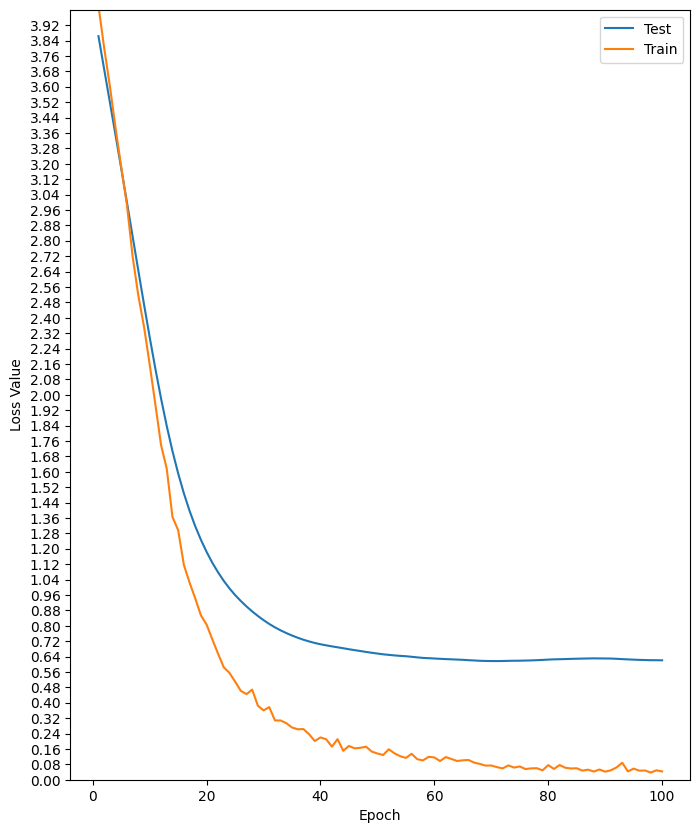

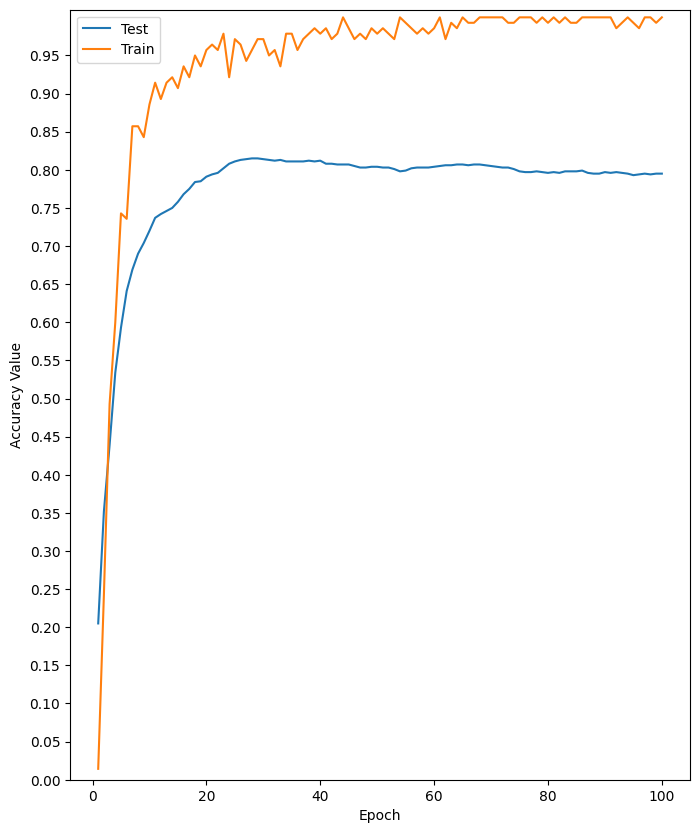

In [18]:

# Création d'un DataFrame pandas avec les données de perte et de précision
data_res = pd.DataFrame({'Loss_test': test_loss_list, 'Loss_Train': loss_list, 'Accuracy_Test': test_acc_list,'Accuracy_Train': train_acc_list,'Epoch': epoch_list})
#############################################

########################################Graph Loss
plt.figure(figsize=(8, 10))
sns.lineplot(x='Epoch', y='Loss_test', data=data_res, label='Test')
sns.lineplot(x='Epoch', y='Loss_Train', data=data_res, label='Train')
plt.legend()
# Modifierles graduations de l'axe des Y
plt.yticks(np.arange(0,4 ,0.08))
# Ajuster les limites de l'axe des Y
plt.ylim([0, 4])
plt.ylabel('Loss Value')
plt.show()
#########################################################

########################################Graph Accuracy
plt.figure(figsize=(8, 10))
sns.lineplot(x='Epoch', y='Accuracy_Test', data=data_res, label='Test')
sns.lineplot(x='Epoch', y='Accuracy_Train', data=data_res, label='Train')
plt.legend()
plt.yticks(np.arange(0, 1, 0.05))
plt.ylim([0, 1.01])
plt.ylabel('Accuracy Value')
plt.show()

